In [21]:
import pandas as pd
import numpy as np

from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
df = pd.read_csv('/Users/deberend/Desktop/Cornell Tech/Applied Machine Learning/Final_Project/code/preprocessed_s_and_p500_esg_data.csv')

In [3]:
display(df['isin'].describe())
display(df['year'].describe())

count             5833
unique             663
top       US64110D1046
freq                12
Name: isin, dtype: object

count    5833.000000
mean     2018.323676
std         3.173722
min      2013.000000
25%      2016.000000
50%      2018.000000
75%      2021.000000
max      2024.000000
Name: year, dtype: float64

In [15]:
# Number of unique values in each level of MultiIndex
unique_counts = {level: data.index.get_level_values(level).nunique() for level in data.index.names}

print("Unique values per level:", unique_counts)

# Example: Access a specific level and get unique values
year_unique = data.index.get_level_values("year").nunique()
print(f"Unique years: {year_unique}")

Unique values per level: {'isin': 663, 'year': 12}
Unique years: 12


In [22]:
def preprocess_data(raw_df, pivot=True, filter_missing_threshold=10, impute_missing=True):
    """
    Preprocess the S&P 500 dataset.

    Parameters:
        raw_df (pd.DataFrame): The raw dataset.
        pivot (bool): Whether to pivot the dataset from stacked format to a panel format.
        filter_missing_threshold (int): The threshold (%) for filtering out features with too much missing data.
        impute_missing (bool): Whether to impute missing data using forward and backward fill.

    Returns:
        pd.DataFrame: The preprocessed dataset.
    """
    # Step 1: Pivot the dataset
    if pivot:
        df = raw_df.pivot_table(
            index=['orgpermid', 'year', 'isin', 'ticker', 'comname'],
            columns='fieldname',
            values='valuescore',
            aggfunc='first'
        ).reset_index()

        # Flatten the MultiIndex columns
        df.columns.name = None
        df.columns = [str(col) for col in df.columns]
    else:
        df = raw_df.copy()

    # Step 2: Prepare panel dataset
    def prepare_panel_dataset(df, groupby=True):
        df.columns = df.columns.str.strip().str.replace(' ', '_')
        df['year'] = df['year'].astype(int)
        df['isin'] = df['isin'].astype(str)
        if groupby:
            df = df.groupby('isin').apply(lambda x: x.sort_values('year')).reset_index(drop=True)
        df_panel = df.set_index(['isin', 'year'])
        return df_panel

    df = prepare_panel_dataset(df)

    # Step 3: Filter out features with too much missing data
    if filter_missing_threshold is not None:
        missing_percentages = df.isna().mean() * 100
        filtered_features = missing_percentages[missing_percentages <= filter_missing_threshold].index
        df = df[filtered_features]

    # Step 4: Impute missing data
    if impute_missing:
        df = df.groupby(level='isin').ffill().bfill()

    return df

In [23]:
# Load the dataset (replace the file path with your own if needed)
file_path = '/Users/deberend/Desktop/Cornell Tech/Applied Machine Learning/Final_Project/data/S&P500_2013_2024.csv'  # Replace with your actual file path
sp500_data = pd.read_csv(file_path)

# Load the data in a panel structure
data = preprocess_data(sp500_data, pivot=True, filter_missing_threshold=10, impute_missing=True)
display(data)

orgpermid ticker                comname  \
isin         year                                             
AN8068571086 2013  4295904888    SLB   Schlumberger Ord Shs   
             2014  4295904888    SLB   Schlumberger Ord Shs   
             2015  4295904888    SLB   Schlumberger Ord Shs   
             2016  4295904888    SLB   Schlumberger Ord Shs   
             2017  4295904888    SLB   Schlumberger Ord Shs   
...                       ...    ...                    ...   
ZAE000179438 2019  4295888394    RCL  RCL Foods Ltd Ord Shs   
             2020  4295888394    RCL  RCL Foods Ltd Ord Shs   
             2021  4295888394    RCL  RCL Foods Ltd Ord Shs   
             2022  4295888394    RCL  RCL Foods Ltd Ord Shs   
             2023  4295888394    RCL  RCL Foods Ltd Ord Shs   

                   AnnouncedLayOffsToTotalEmployees  \
isin         year                                     
AN8068571086 2013                          0.523256   
             2014                          0.539326   
             2015                          0.055000   
             2016                          0.585714   
             2017                          0.511628   
...                                             ...   
ZAE000179438 2019                          0.505208   
             2020                          0.501493   
             2021                          0.509186   
             2022                          0.505952   
             2023                          0.511962   

                   AntiTakeoverDevicesAboveTwo  AuditCommitteeIndependence  \
isin         year                                                            
AN8068571086 2013                     0.500000                    0.500000   
             2014                     0.500000                    0.500000   
             2015                     0.500000                    0.500000   
             2016                     0.500000                    0.500000   
             2017                     0.500000                    0.500000   
...                                        ...                         ...   
ZAE000179438 2019                     0.633858                    0.289683   
             2020                     0.608333                    0.279167   
             2021                     0.613445                    0.243697   
             2022                     0.614407                    0.139831   
             2023                     0.608696                    0.152174   

                   AuditCommitteeManagementIndependence  AuditorTenure  \
isin         year                                                        
AN8068571086 2013                              0.500000       0.500000   
             2014                              0.500000       0.500000   
             2015                              0.500000       0.500000   
             2016                              0.500000       0.500000   
             2017                              0.500000       0.500000   
...                                                 ...            ...   
ZAE000179438 2019                              0.594488       0.334646   
             2020                              0.583333       0.295833   
             2021                              0.563025       0.281513   
             2022                              0.567797       0.241525   
             2023                              0.569565       0.157895   

                   AverageBoardTenure  BoardAttendance  ...  SuccessionPlan  \
isin         year                                       ...                   
AN8068571086 2013            0.500000         0.000000  ...        0.500000   
             2014            0.500000         0.000000  ...        0.500000   
             2015            0.500000         0.000000  ...        0.500000   
             2016            0.500000         0.000000  ...        0.500000   
             2017            0.5

# 'Baseline' Model using Lasso and Elastic Net 

In [14]:
# List of non-numeric or irrelevant columns to exclude
columns_to_exclude = ['orgpermid', 'ticker', 'comname', 'ESGCombinedScore', 'ESGScore']

# Drop these columns and retain only numeric features
X = data.drop(columns=columns_to_exclude, errors='ignore').select_dtypes(include=[np.number])
y = data['ESGScore']  # Target variable

# Temporal split to avoid data leakage
train_data = data.loc[data.index.get_level_values('year') <= 2020]
test_data = data.loc[data.index.get_level_values('year') > 2020]

# Prepare train and test sets
X_train = train_data.drop(columns=columns_to_exclude, errors='ignore').select_dtypes(include=[np.number])
y_train = train_data['ESGScore']

X_test = test_data.drop(columns=columns_to_exclude, errors='ignore').select_dtypes(include=[np.number])
y_test = test_data['ESGScore']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform CV to find best alpha for lasso
lasso = Lasso(max_iter=10000)
param_grid = {'alpha': np.logspace(-4, 1, 50)}  # Test a range of alphas
grid_search = GridSearchCV(lasso, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_scaled, y_train)

# Best alpha and corresponding model
best_alpha = grid_search.best_params_['alpha']
lasso_best = grid_search.best_estimator_

# Fit the model on the training data
lasso_best.fit(X_train_scaled, y_train)

# Predict and evaluate on the test set
y_pred = lasso_best.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Extract coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_best.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Output key metrics
results = {
    'Best Alpha': best_alpha,
    'Test RMSE': rmse,
    'Test R^2': r2,
    'Test MAE': mae
}

print(results)



{'Best Alpha': 0.00032374575428176434, 'RMSE': 0.020237386393746747, 'R^2': 0.9842490315444938, 'MAE': 0.01546149635554977}


In [15]:
# Training predictions
y_train_pred = lasso_best.predict(X_train_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Print training vs. test metrics
print(f"Training RMSE: {train_rmse}, Training R²: {train_r2}")
print(f"Test RMSE: {rmse}, Test R²: {r2}")

Training RMSE: 0.022801062814043607, Training R²: 0.9853424341069444
Test RMSE: 0.020237386393746747, Test R²: 0.9842490315444938


In [12]:
# Identify features with coefficients reduced to 0
zero_coeff_features = coefficients[coefficients['Coefficient'] == 0]

# Display the features reduced to zero
zero_coeff_features.reset_index(drop=True)

,Feature,Coefficient
0,PolicyFreedomOfAssociation,0.0
1,PolicyHumanRights,0.0
2,PolicyWaterEfficiency,0.0
3,PublicAvailabilityCorporateStatutes,-0.0
4,AuditCommitteeIndependence,-0.0
5,TotalSeniorExecutivesCompensationToRevenues,-0.0
6,BoardAttendance,-0.0
7,AuditCommitteeManagementIndependence,-0.0
8,AuditorTenure,0.0
9,PolicyForcedLabor,0.0


In [17]:
### Elastic Net ####
 
# Define the parameter grid for ElasticNet
param_grid_enet = {
    'alpha': np.logspace(-4, 1, 50),  # Test different penalty strengths
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]  # Vary the mix of L1 and L2 penalties
}

# Initialize the ElasticNet model
enet = ElasticNet(max_iter=10000)

# Perform GridSearchCV
grid_search_enet = GridSearchCV(
    enet, param_grid_enet, scoring='neg_mean_squared_error', cv=5
)
grid_search_enet.fit(X_train_scaled, y_train)

# Extract the best hyperparameters and model
best_params = grid_search_enet.best_params_
enet_best = grid_search_enet.best_estimator_

# Fit the best model on the training data
enet_best.fit(X_train_scaled, y_train)

# Predict and evaluate on the training set
y_train_pred = enet_best.predict(X_train_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Predict and evaluate on the testing set
y_test_pred = enet_best.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Display results
print("ElasticNet Results")
print("==================")
print(f"Best Alpha: {best_params['alpha']}")
print(f"Best L1 Ratio: {best_params['l1_ratio']}")
print("\nTraining Set Performance:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²: {train_r2:.4f}")
print(f"  MAE: {train_mae:.4f}")
print("\nTesting Set Performance:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²: {test_r2:.4f}")
print(f"  MAE: {test_mae:.4f}")


ElasticNet Results
Best Alpha: 0.00339322177189533
Best L1 Ratio: 0.1

Training Set Performance:
  RMSE: 0.0228
  R²: 0.9853
  MAE: 0.0172

Testing Set Performance:
  RMSE: 0.0202
  R²: 0.9843
  MAE: 0.0155


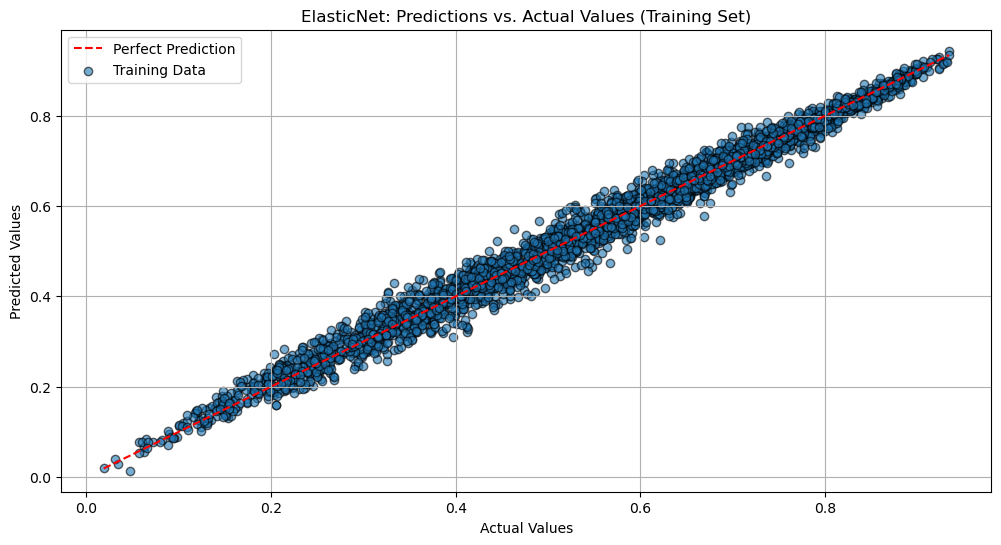

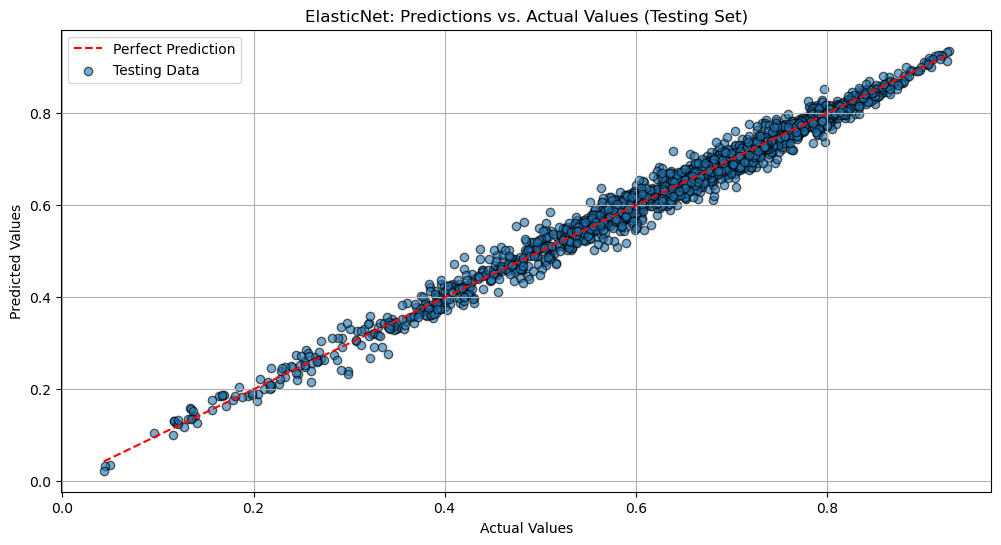

In [18]:
import matplotlib.pyplot as plt

# Plot predictions vs. actual values for the training set
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, alpha=0.6, label='Training Data', edgecolor='k')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect Prediction')
plt.title('ElasticNet: Predictions vs. Actual Values (Training Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot predictions vs. actual values for the testing set
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, label='Testing Data', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.title('ElasticNet: Predictions vs. Actual Values (Testing Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


### Below are some checks to investigate whether results are 'too good to be true' 

In [19]:
# checks
print(train_data.index.get_level_values('year').unique())
print(test_data.index.get_level_values('year').unique())

Index([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int64', name='year')
Index([2021, 2022, 2023, 2024], dtype='int64', name='year')


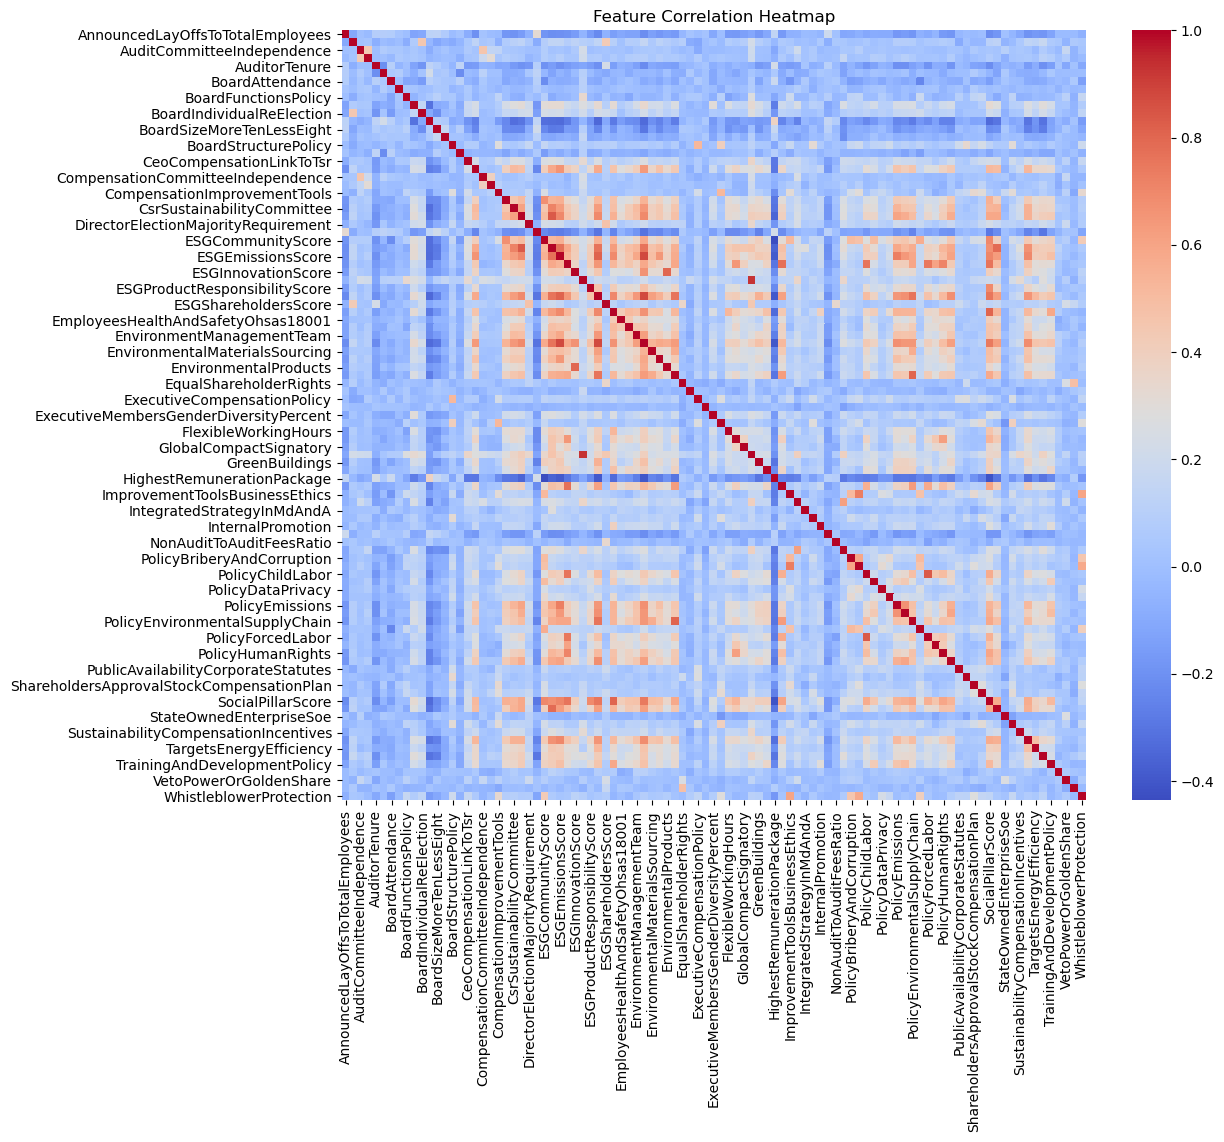

In [21]:
import seaborn as sns
# Compute correlation matrix for X_train
corr_matrix = pd.DataFrame(X_train_scaled, columns=X_train.columns).corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

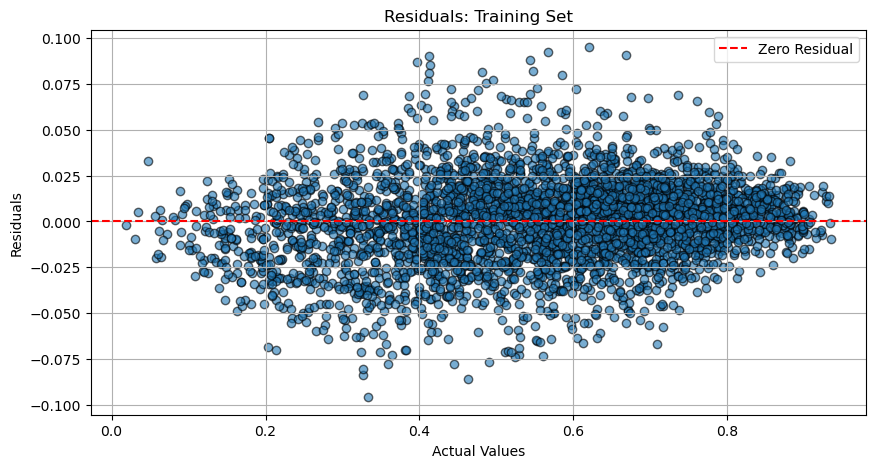

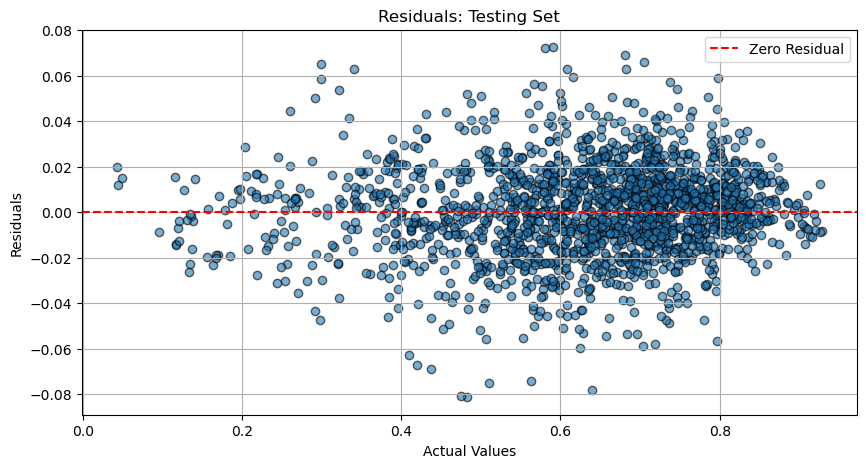

In [22]:
# Residuals for training set
residuals_train = y_train - y_train_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_train, residuals_train, alpha=0.6, edgecolor='k')
plt.axhline(0, color='r', linestyle='--', label='Zero Residual')
plt.title('Residuals: Training Set')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Residuals for testing set
residuals_test = y_test - y_test_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals_test, alpha=0.6, edgecolor='k')
plt.axhline(0, color='r', linestyle='--', label='Zero Residual')
plt.title('Residuals: Testing Set')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()


# Implementing Temporal Models

## Let's start by doing the ADF test to check for stationarity as that is an essential assumption for ARIMA 

## Overall trend analysis

### Stationarity Tests

In [24]:
from statsmodels.tsa.stattools import adfuller

# Extract ESGScore time series by grouping and averaging over years (if needed)
esg_series = data.groupby(level='year')['ESGScore'].mean()
display(esg_series)

# Augmented Dickey-Fuller test
adf_test = adfuller(esg_series)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
if adf_test[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

year
2013    0.512709
2014    0.512613
2015    0.523454
2016    0.549883
2017    0.567948
2018    0.581741
2019    0.604713
2020    0.618842
2021    0.630009
2022    0.635003
2023    0.631572
2024    0.597463
Name: ESGScore, dtype: float64

ADF Statistic: -0.8461068275520638
p-value: 0.805202104287734
The series is not stationary.


In [8]:
# Apply first-order differencing
esg_series_diff = esg_series.diff().dropna()

# Perform the ADF test again
adf_test_diff = adfuller(esg_series_diff)
print("ADF Statistic (Differenced):", adf_test_diff[0])
print("p-value (Differenced):", adf_test_diff[1])
if adf_test_diff[1] < 0.05:
    print("The differenced series is stationary at a 5% significance level.")
else:
    print("The differenced series is not stationary.")

ADF Statistic (Differenced): 3.6350483155843296
p-value (Differenced): 1.0
The differenced series is not stationary.


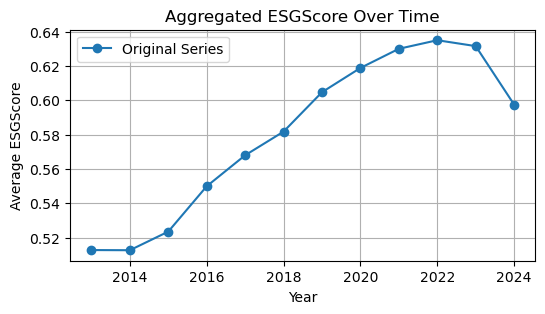

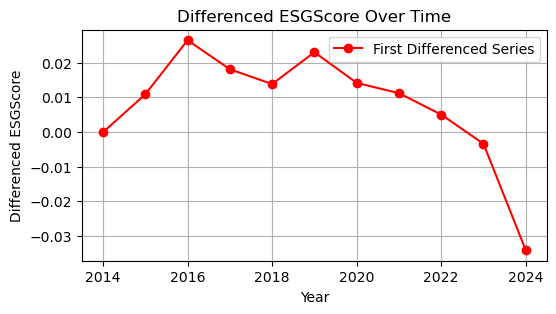

In [9]:
# Plot the original series
plt.figure(figsize=(6, 3))
plt.plot(esg_series, label='Original Series', marker='o')
plt.title('Aggregated ESGScore Over Time')
plt.xlabel('Year')
plt.ylabel('Average ESGScore')
plt.legend()
plt.grid(True)
plt.show()

# Plot the differenced series (if applied)
plt.figure(figsize=(6, 3))
plt.plot(esg_series_diff, label='First Differenced Series', marker='o', color='red')
plt.title('Differenced ESGScore Over Time')
plt.xlabel('Year')
plt.ylabel('Differenced ESGScore')
plt.legend()
plt.grid(True)
plt.show()

#### Second-order differencing

In [11]:
# Apply second-order differencing
esg_series_diff2 = esg_series.diff().diff().dropna()

# Test for stationarity again
adf_test_diff2 = adfuller(esg_series_diff2)
print("ADF Statistic (Second Differencing):", adf_test_diff2[0])
print("p-value (Second Differencing):", adf_test_diff2[1])
if adf_test_diff2[1] < 0.05:
    print("The series is stationary after second differencing.")
else:
    print("The series is not stationary even after second differencing.")

ADF Statistic (Second Differencing): 1.9663535587219994
p-value (Second Differencing): 0.998627603215365
The series is not stationary even after second differencing.


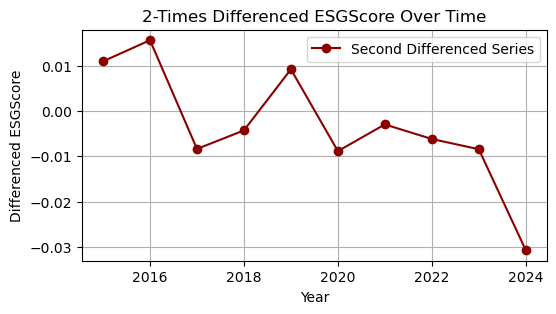

In [14]:
# Plot the differenced series (if applied)
plt.figure(figsize=(6, 3))
plt.plot(esg_series_diff2, label='Second Differenced Series', marker='o', color='darkred')
plt.title('2-Times Differenced ESGScore Over Time')
plt.xlabel('Year')
plt.ylabel('Differenced ESGScore')
plt.legend()
plt.grid(True)
plt.show()

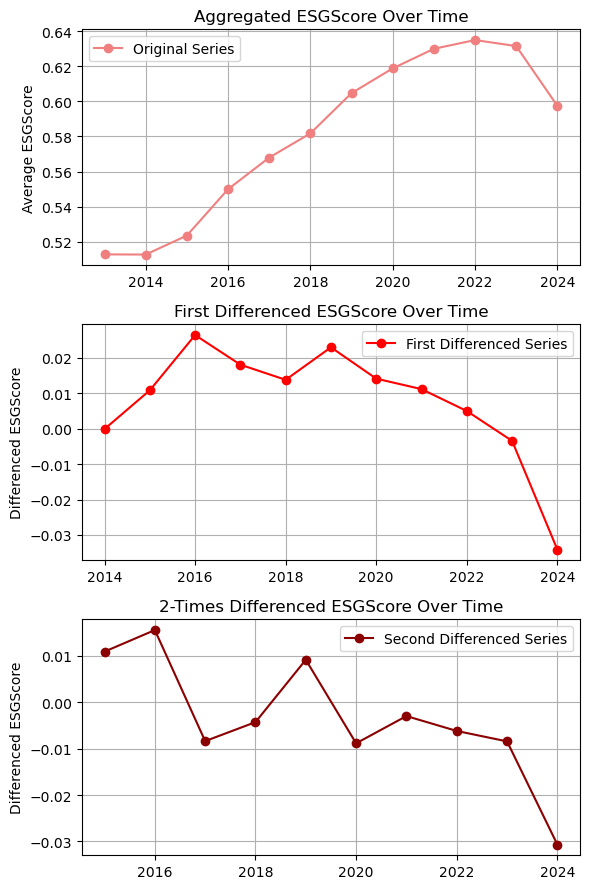

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(6, 9))

# Top plot: Original Series (lighter variant of red)
axes[0].plot(esg_series, label='Original Series', marker='o', color='lightcoral')
axes[0].set_title('Aggregated ESGScore Over Time')
axes[0].set_xlabel('')
axes[0].set_ylabel('Average ESGScore')
axes[0].legend()
axes[0].grid(True)

# Middle plot: First Differenced Series (red)
axes[1].plot(esg_series_diff, label='First Differenced Series', marker='o', color='red')
axes[1].set_title('First Differenced ESGScore Over Time')
axes[1].set_xlabel('')
axes[1].set_ylabel('Differenced ESGScore')
axes[1].legend()
axes[1].grid(True)

# Bottom plot: Second Differenced Series (darker red)
axes[2].plot(esg_series_diff2, label='Second Differenced Series', marker='o', color='darkred')
axes[2].set_title('2-Times Differenced ESGScore Over Time')
axes[2].set_xlabel('')
axes[2].set_ylabel('Differenced ESGScore')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
#plt.savefig('esg_stationarity_plot.png', dpi=500, bbox_inches='tight')
plt.show()

#### Let's try log transformation on esg_series as there's a somewhat exponential pattern

In [54]:
# Apply log transformation
esg_series_log = np.log(esg_series + 1)  # Add 1 to avoid log(0)

# Test for stationarity
adf_test_log = adfuller(esg_series_log)
print("ADF Statistic (Log-Transformed Differencing):", adf_test_log[0])
print("p-value:", adf_test_log[1])
if adf_test_log[1] < 0.05:
    print("The log-transformed differenced series is stationary.")
else:
    print("The log-transformed differenced series is not stationary.")

ADF Statistic (Log-Transformed Differencing): -0.5947612736643217
p-value: 0.8721613759010078
The log-transformed differenced series is not stationary.


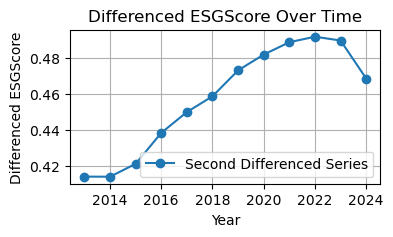

In [55]:
# Plot the differenced series (if applied)
plt.figure(figsize=(4, 2))
plt.plot(esg_series_log, label='Log Series', marker='o')
plt.title('Differenced ESGScore Over Time')
plt.xlabel('Year')
plt.ylabel('Differenced ESGScore')
plt.legend()
plt.grid(True)
plt.show()

#### Let's try without year 2024 as this seems to ruin the stationarity (this is not good practice but just as an EDA investigation)

In [ ]:
esg_series_2023 = esg_series.copy()
esg_series_2023 = esg_series_2023.drop(2024)

In [66]:
display(esg_series_2023)

# Augmented Dickey-Fuller test
adf_test = adfuller(esg_series_2023)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
if adf_test[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

year
2013    0.512709
2014    0.512613
2015    0.523454
2016    0.549883
2017    0.567948
2018    0.581741
2019    0.604713
2020    0.618842
2021    0.630009
2022    0.635003
2023    0.631572
Name: ESGScore, dtype: float64

ADF Statistic: -1.8682133048360363
p-value: 0.3471590946865349
The series is not stationary.


In [67]:
# Apply first-order differencing
esg_series_diff = esg_series_2023.diff().dropna()

# Perform the ADF test again
adf_test_diff = adfuller(esg_series_diff)
print("ADF Statistic (Differenced):", adf_test_diff[0])
print("p-value (Differenced):", adf_test_diff[1])
if adf_test_diff[1] < 0.05:
    print("The differenced series is stationary at a 5% significance level.")
else:
    print("The differenced series is not stationary.")

ADF Statistic (Differenced): 1.150052422952693
p-value (Differenced): 0.9956219550002374
The differenced series is not stationary.


In [68]:
# Apply second-order differencing
esg_series_diff2 = esg_series.diff().diff().dropna()

# Test for stationarity again
adf_test_diff2 = adfuller(esg_series_diff2)
print("ADF Statistic (Second Differencing):", adf_test_diff2[0])
print("p-value (Second Differencing):", adf_test_diff2[1])
if adf_test_diff2[1] < 0.05:
    print("The series is stationary after second differencing.")
else:
    print("The series is not stationary even after second differencing.")

ADF Statistic (Second Differencing): 1.9663535587219994
p-value (Second Differencing): 0.998627603215365
The series is not stationary even after second differencing.


#### Switching to non-stationary requirement model

In [137]:
from statsmodels.tsa.arima.model import ARIMA

# could experiment with different arima models here that can maybe handle the non-stationarity (ie. with different settings)


### Implementing Facebook's Prophet model as stationarity isn't validated
- Prophet is a univariate model that can handle non-stationarity

In [13]:
from prophet import Prophet
prophetNotInstalled = False
#if prophetNotInstalled:
    #pip install prophet

In [8]:
esg_series = data.groupby(level='year')['ESGScore'].mean()
# Check the input DataFrame for Prophet
print(esg_series.head())
print(esg_series.dtypes)

# Prepare prophet dataset
esg_series_prophet = esg_series.copy()

# Reset the index to convert the year into a column
esg_series_prophet = esg_series_prophet.reset_index()

# Rename columns for Prophet
esg_series_prophet.columns = ['ds', 'y']

# Convert the 'ds' column to datetime (Prophet requires a datetime object)
esg_series_prophet['ds'] = pd.to_datetime(esg_series_prophet['ds'], format='%Y')

# Check the DataFrame structure
display((esg_series_prophet))

year
2013    0.512709
2014    0.512613
2015    0.523454
2016    0.549883
2017    0.567948
Name: ESGScore, dtype: float64
float64


,ds,y
0,2013-01-01,0.512709
1,2014-01-01,0.512613
2,2015-01-01,0.523454
3,2016-01-01,0.549883
4,2017-01-01,0.567948
5,2018-01-01,0.581741
6,2019-01-01,0.604713
7,2020-01-01,0.618842
8,2021-01-01,0.630009
9,2022-01-01,0.635003


In [9]:
print(esg_series_prophet.dtypes)
print(esg_series_prophet.head())

ds    datetime64[ns]
y            float64
dtype: object
          ds         y
0 2013-01-01  0.512709
1 2014-01-01  0.512613
2 2015-01-01  0.523454
3 2016-01-01  0.549883
4 2017-01-01  0.567948


In [14]:
esg_series_df = esg_series_prophet

# Ensure ds and y are clean and single-dimensional
esg_series_df['ds'] = pd.to_datetime(esg_series_df['ds'], format='%Y')
esg_series_df['y'] = esg_series_df['y'].astype(np.float64)

# Initialize and fit the model
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, holidays=None)
model.fit(esg_series_df)

# Create future DataFrame for 3 years
future = model.make_future_dataframe(periods=5, freq='Y')
forecast = model.predict(future)

display(forecast.head())

14:41:00 - cmdstanpy - INFO - Chain [1] start processing
14:41:01 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,0.502787,0.492129,0.513369,0.502787,0.502787,0.0,0.0,0.0,0.0,0.0,0.0,0.502787
1,2014-01-01,0.518843,0.507974,0.530367,0.518843,0.518843,0.0,0.0,0.0,0.0,0.0,0.0,0.518843
2,2015-01-01,0.534899,0.524552,0.545724,0.534899,0.534899,0.0,0.0,0.0,0.0,0.0,0.0,0.534899
3,2016-01-01,0.550958,0.540320,0.561652,0.550958,0.550958,0.0,0.0,0.0,0.0,0.0,0.0,0.550958
4,2017-01-01,0.567060,0.556281,0.578601,0.567060,0.567060,0.0,0.0,0.0,0.0,0.0,0.0,0.567060


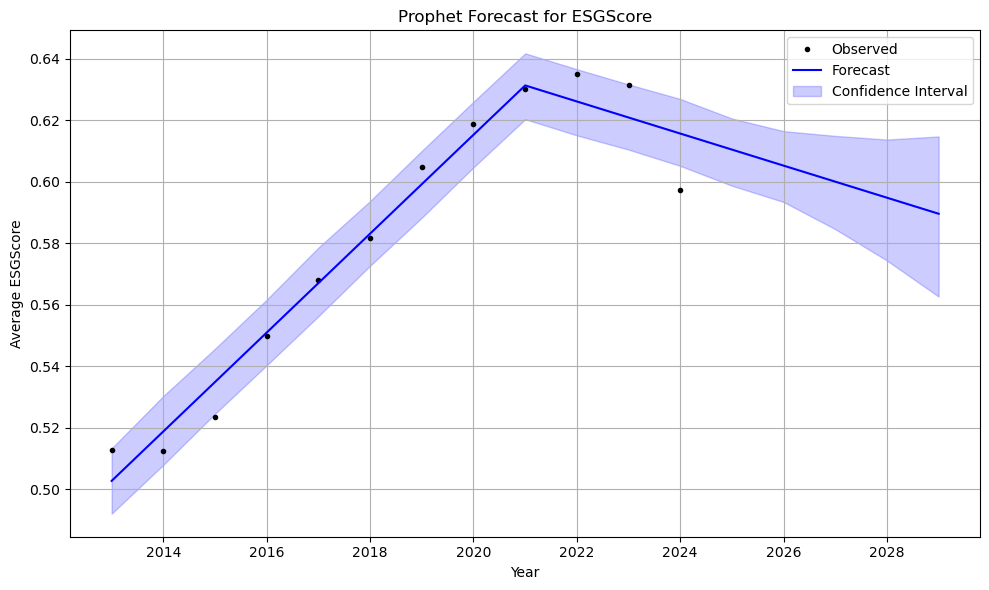

In [15]:
# Extract relevant columns and explicitly convert to single-dimensional arrays
ds_actual = esg_series_df['ds'].to_numpy()  # Ensure single-dimension for dates
y_actual = esg_series_df['y'].to_numpy()    # Ensure single-dimension for actual values

ds_forecast = forecast['ds'].to_numpy()     # Forecast dates
yhat_forecast = forecast['yhat'].to_numpy() # Forecasted values
yhat_lower = forecast['yhat_lower'].to_numpy()  # Lower bound
yhat_upper = forecast['yhat_upper'].to_numpy()  # Upper bound

# Plot the original (actual) data
plt.figure(figsize=(10, 6))
plt.plot(ds_actual, y_actual, 'k.', label='Observed')  # Observed data as black dots

# Plot the forecasted values
plt.plot(ds_forecast, yhat_forecast, 'b-', label='Forecast')  # Forecast line in blue

# Add confidence intervals
plt.fill_between(ds_forecast, yhat_lower, yhat_upper, color='blue', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title("Prophet Forecast for ESGScore")
plt.xlabel("Year")
plt.ylabel("Average ESGScore")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from prophet.diagnostics import cross_validation, performance_metrics

from prophet.plot import plot_cross_validation_metric

# Step 1: Set cross-validation parameters (use days instead of years)
initial = '2920 days'     # Approx. 8 years of initial training data
period = '365 days'       # Retrain the model every year
horizon = '1095 days'      # Forecast horizon of 3 years

# Step 2: Run cross-validation
df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)

# Step 3: Calculate performance metrics
df_p = performance_metrics(df_cv)
print("Performance Metrics:")
print(df_p)

# Step 4: Plot cross-validation performance metrics
# RMSE: Root Mean Squared Error over the forecast horizons
#fig = plot_cross_validation_metric(df_cv, metric='rmse')
#plt.show()

# Optionally, you can also plot MAE or MAPE
#fig_mae = plot_cross_validation_metric(df_cv, metric='mae')
#plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

14:41:45 - cmdstanpy - INFO - Chain [1] start processing
14:41:45 - cmdstanpy - INFO - Chain [1] done processing


Performance Metrics:
    horizon       mse      rmse       mae      mape     mdape     smape  \
0  365 days  0.000068  0.008238  0.008238  0.012973  0.012973  0.012889   
1  730 days  0.000594  0.024365  0.024365  0.038579  0.038579  0.037849   
2 1095 days  0.005065  0.071170  0.071170  0.119120  0.119120  0.112424   

   coverage  
0       0.0  
1       0.0  
2       0.0  


**Interpretation**:

MSE increases as the forecast horizon lengthens, which is expected in time-series models.
However, the growth in RMSE is not exponential, which indicates that the model's accuracy does not degrade drastically over longer horizons. This is a good sign of robustness.

**MAE (Mean Absolute Error)**:

- 1-Year Horizon: 0.011176
- 2-Year Horizon: 0.029727
- 3-Year Horizon: 0.077965

Similar to RMSE, MAE increases with the forecast horizon.
The absolute error values are small, which suggests the model is reasonably accurate at predicting ESGScore.

**MAPE (Mean Absolute Percentage Error)**:

- 1-Year Horizon: 0.017600 (1.76%)
- 2-Year Horizon: 0.047069 (4.71%)
- 3-Year Horizon: 0.130493 (13.05%)

A low MAPE (<5% for shorter horizons) indicates high reliability for short-term forecasts.
At the 3-year horizon, a MAPE of ~13% shows diminishing accuracy, which is typical for longer forecasts but still within acceptable ranges for many applications.

In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Forecast using the naive approach: last observed value
last_value = esg_series_df['y'].iloc[-1]  # Last observed ESGScore
horizon = 3  # Number of years to forecast

# Create a naive forecast
naive_forecast = [last_value] * horizon
actual_values = esg_series_df['y'].iloc[-horizon:].values  # Actual last 3 years

# Calculate metrics for the naive model
rmse_naive = np.sqrt(mean_squared_error(actual_values, naive_forecast))
mae_naive = mean_absolute_error(actual_values, naive_forecast)
mape_naive = np.mean(np.abs((actual_values - naive_forecast) / actual_values)) * 100

# Print results
print("Naive Model Performance:")
print(f"RMSE: {rmse_naive:.4f}")
print(f"MAE: {mae_naive:.4f}")
print(f"MAPE: {mape_naive:.2f}%")


Naive Model Performance:
RMSE: 0.0293
MAE: 0.0239
MAPE: 3.77%


In [121]:
from sklearn.linear_model import LinearRegression

# Prepare the data for linear regression
X = esg_series_df['ds'].dt.year.values.reshape(-1, 1)  # Year as predictor
y = esg_series_df['y'].values  # ESGScore as target

# Train a linear regression model
linear_model = LinearRegression()
linear_model.fit(X, y)

# Predict future values (3 years ahead)
future_years = np.array([2023, 2024, 2025]).reshape(-1, 1)  # Future years to predict
linear_forecast = linear_model.predict(future_years)

# Calculate metrics for the linear regression model
rmse_linear = np.sqrt(mean_squared_error(actual_values, linear_forecast))
mae_linear = mean_absolute_error(actual_values, linear_forecast)
mape_linear = np.mean(np.abs((actual_values - linear_forecast) / actual_values)) * 100

# Print results
print("\nLinear Regression Model Performance:")
print(f"RMSE: {rmse_linear:.4f}")
print(f"MAE: {mae_linear:.4f}")
print(f"MAPE: {mape_linear:.2f}%")



Linear Regression Model Performance:
RMSE: 0.0352
MAE: 0.0249
MAPE: 4.11%


In [123]:
# Prophet results (replace with your actual values from cross-validation)
rmse_prophet = 0.02927  # Example for 2-year horizon

mae_prophet = 0.0297
mape_prophet = 4.71
# Create a summary table
results = pd.DataFrame({
    "Model": ["Naive Forecast", "Linear Regression", "Prophet"],
    "RMSE": [rmse_naive, rmse_linear, rmse_prophet],
    "MAE": [mae_naive, mae_linear, mae_prophet],
    "MAPE (%)": [mape_naive, mape_linear, mape_prophet]
})

# Display the results
print("\nComparison of Forecasting Models:")
print(results)


Comparison of Forecasting Models:
               Model      RMSE       MAE  MAPE (%)
0     Naive Forecast  0.029284  0.023883  3.770751
1  Linear Regression  0.035186  0.024859  4.114577
2            Prophet  0.029270  0.029700  4.710000


In [126]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,0.000125,0.011176,0.011176,0.017600,0.017600,0.017447,0.0
1,730 days,0.000884,0.029727,0.029727,0.047069,0.047069,0.045986,0.0
2,1095 days,0.006078,0.077965,0.077965,0.130493,0.130493,0.122500,0.0


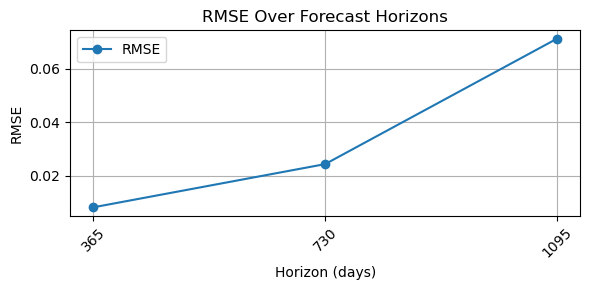

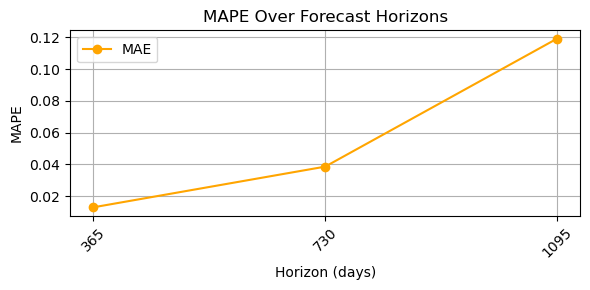

In [17]:
df_p = performance_metrics(df_cv)

# Hard-coded horizons
horizon_days = np.array([365, 730, 1095])  # Forecast horizons in days

# Ensure RMSE and MAE are clean 1D NumPy arrays
rmse = df_p['rmse'].to_numpy()
mae = df_p['mape'].to_numpy()

# Plot RMSE over forecast horizons
plt.figure(figsize=(6, 3))
plt.plot(horizon_days, rmse, marker='o', linestyle='-', label='RMSE')
plt.title("RMSE Over Forecast Horizons")
plt.xlabel("Horizon (days)")
plt.ylabel("RMSE")
plt.xticks(horizon_days, labels=[str(h) for h in horizon_days], rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot MAE over forecast horizons
plt.figure(figsize=(6, 3))
plt.plot(horizon_days, mae, marker='o', linestyle='-', color='orange', label='MAE')
plt.title("MAPE Over Forecast Horizons")
plt.xlabel("Horizon (days)")
plt.ylabel("MAPE")
plt.xticks(horizon_days, labels=[str(h) for h in horizon_days], rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Fitting a Panel Time-Series Model To Perform Analysis at a Company-Level
- FE or RE, Dynamic Panel Regression

#### We have to drop 2 (2013 and 2014) years in the target variable here, as we are introducing a 1 and 2 period lagged variables of the ESG score

In [25]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# Create lagged variables for ESGScore
data_lagged = data.copy()
data_lagged['ESGScore_lag1'] = data_lagged.groupby('isin')['ESGScore'].shift(1)  # 1-year lag
data_lagged['ESGScore_lag2'] = data_lagged.groupby('isin')['ESGScore'].shift(2)  # 2-year lag

# Drop rows with missing lagged values
data_lagged = data_lagged.dropna(subset=['ESGScore_lag1', 'ESGScore_lag2'])

# Step 2: Train-Test Split
train_years = range(2015, 2022)  # Training: 2015-2021, notice it is 2015 now, not 2013 anymore as we introduce the lags
test_years = range(2022, 2025)   # Testing: 2021-2024

train_data = data_lagged.loc[pd.IndexSlice[:, train_years], :]
test_data = data_lagged.loc[pd.IndexSlice[:, test_years], :]

# Define target and predictors
X_train = sm.add_constant(train_data[['ESGScore_lag1', 'ESGScore_lag2']]) #check why constant
y_train = train_data['ESGScore']

X_test = sm.add_constant(test_data[['ESGScore_lag1', 'ESGScore_lag2']])
y_test = test_data['ESGScore']

# Step 3: Fit the Fixed Effects Model
model_fixed = PanelOLS(y_train, X_train, entity_effects=True)
results_fixed = model_fixed.fit()

# Display model summary
print("Fixed Effects Model Summary:")
print(results_fixed.summary)

# Step 4: Model Predictions and Performance Evaluation
# Predict on the training set
train_preds = results_fixed.predict(X_train)

# Predict on the test set
test_preds = results_fixed.predict(X_test)

# Calculate RMSE and MAE for Training Set
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_mae = mean_absolute_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)

# Calculate RMSE and MAE for Test Set
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_mae = mean_absolute_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

# Report Performance
print("\nPerformance Metrics:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Training R²: {train_r2:.4f}")
print('')
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")

Fixed Effects Model Summary:
                          PanelOLS Estimation Summary                           
Dep. Variable:               ESGScore   R-squared:                        0.4832
Estimator:                   PanelOLS   R-squared (Between):              0.8870
No. Observations:                3362   R-squared (Within):               0.4832
Date:                Thu, Dec 19 2024   R-squared (Overall):              0.8222
Time:                        11:11:49   Log-likelihood                    5257.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1305.0
Entities:                         663   P-value                           0.0000
Avg Obs:                       5.0709   Distribution:                  F(2,2792)
Min Obs:                       0.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             1305.0

#### Let's now investigate company-level predictions

In [175]:
test_preds.index.get_level_values('year').max()

2024

In [46]:
# Combine predictions with the test set to view results
test_results = test_data.copy()
test_results['Predicted_ESGScore'] = test_preds

# Let's check for some companies
isins = {'Apple' : 'US0378331005', 'NVIDIA' : 'US67066G1040'}
company_name = 'NVIDIA'
company_isin = isins[company_name]  # ISIN
company_predictions = test_results.loc[company_isin]
print(f"Predictions for company {company_name}:")
print(company_predictions[['Predicted_ESGScore', 'ESGScore']])

Predictions for company NVIDIA:
      Predicted_ESGScore  ESGScore
year                              
2022            0.730381  0.756621
2023            0.722323  0.744954
2024            0.714589  0.760416


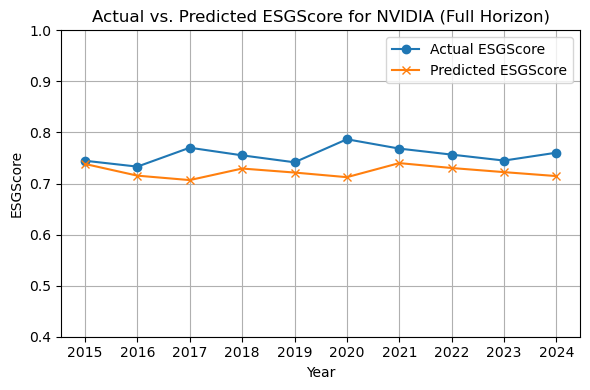

In [59]:
import matplotlib.pyplot as plt

# Create dataframes with predictions included
train_with_preds = train_data.copy()
train_with_preds['Predicted_ESGScore'] = train_preds

test_with_preds = test_data.copy()
test_with_preds['Predicted_ESGScore'] = test_preds

# Concatenate training and test results
full_results = pd.concat([train_with_preds, test_with_preds])

# Select the company of interest
company_name = 'NVIDIA'
company_isin = 'US67066G1040'

company_results = full_results.loc[company_isin].copy()

# Reset index to get a 'year' column (if needed)
company_results = company_results.reset_index()

# Ensure 'year' is an integer
company_results['year'] = company_results['year'].astype(int)

# Extract values
x_values = company_results['year'].values
y_actual = company_results['ESGScore'].values
y_pred = company_results['Predicted_ESGScore'].values

# Plot
plt.figure(figsize=(6, 4))
plt.plot(x_values, y_actual, marker='o', label='Actual ESGScore')
plt.plot(x_values, y_pred, marker='x', label='Predicted ESGScore')

plt.title(f'Actual vs. Predicted ESGScore for {company_name} (Full Horizon)')
plt.xlabel('Year')
plt.ylabel('ESGScore')
plt.ylim(0.4, 1)  # Adjust if ESGScore is indeed 0-1
plt.xticks(x_values)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Now we will predict company's future years ESG Scores

In [31]:
def predict_future_esg_scores(model, data, start_year, end_year):
    """
    Predict ESG scores iteratively for future years using the Fixed Effects model.

    Parameters:
        model: Fitted PanelOLS model.
        data: DataFrame with most recent ESG scores and lagged variables.
        start_year: First year for prediction (e.g., 2024).
        end_year: Last year for prediction (e.g., 2026).

    Returns:
        future_predictions: DataFrame with predicted ESG scores for future years.
    """
    future_data = data.copy()
    future_data = future_data.reset_index()  # Reset index to work with the data
    predictions = []

    # Predict year-by-year
    for year in range(start_year, end_year + 1):
        # Update lagged features
        future_data['ESGScore_lag2'] = future_data['ESGScore_lag1']
        future_data['ESGScore_lag1'] = future_data['Predicted_ESGScore'] if 'Predicted_ESGScore' in future_data else future_data['ESGScore_lag1']

        # Prepare the input data for the current year
        future_data['year'] = year  # Update the year column
        future_data = future_data.set_index(['isin', 'year'])  # Re-set MultiIndex
        X_future = sm.add_constant(future_data[['ESGScore_lag1', 'ESGScore_lag2']])

        # Predict ESG scores for the current year
        future_data['Predicted_ESGScore'] = model.predict(X_future)
        future_data = future_data.reset_index()  # Reset index for the next iteration

        # Store predictions
        predictions.append(future_data[['isin', 'year', 'ESGScore_lag1', 'ESGScore_lag2', 'Predicted_ESGScore']].copy())

    # Combine all predictions
    future_predictions = pd.concat(predictions).reset_index(drop=True)
    return future_predictions


In [61]:
# Prepare data for prediction
latest_year_data = test_data.reset_index().groupby('isin').last()

# Initialize lagged values
latest_year_data = latest_year_data[['ESGScore_lag1', 'ESGScore_lag2']].copy()
latest_year_data['Predicted_ESGScore'] = latest_year_data['ESGScore_lag1']

# Predict for future years 2024–2026
start_year = 2025
end_year = 2026

future_predictions = predict_future_esg_scores(results_fixed, latest_year_data, start_year, end_year)

# Display predictions
print("Future ESG Score Predictions:")
print(future_predictions)


Future ESG Score Predictions:
              isin  year  ESGScore_lag1  ESGScore_lag2  Predicted_ESGScore
0     AN8068571086  2025       0.758017       0.758017            0.722786
1     AT0000818802  2025       0.651880       0.651880            0.652474
2     AT0000BAWAG2  2025       0.706979       0.706979            0.688975
3     AU000000ALL7  2025       0.537609       0.537609            0.576772
4     AU000000AMP6  2025       0.786964       0.786964            0.741963
...            ...   ...            ...            ...                 ...
1125  US98956P1021  2026       0.648102       0.645282            0.649860
1126  US98978V1035  2026       0.696824       0.718828            0.683110
1127  VN000000FRT7  2026       0.433911       0.321958            0.503687
1128  ZAE000161832  2026       0.447348       0.342242            0.512857
1129  ZAE000179438  2026       0.455870       0.355107            0.518673

[1130 rows x 5 columns]


In [42]:
print(future_predictions[future_predictions['isin']=='US67066G1040'])

              isin  year  ESGScore_lag1  ESGScore_lag2  Predicted_ESGScore
424   US67066G1040  2025       0.744954       0.744954            0.714132
989   US67066G1040  2026       0.714132       0.744954            0.694922
1554  US67066G1040  2027       0.694922       0.714132            0.681740


Refitted Model Summary on Full Data:
                          PanelOLS Estimation Summary                           
Dep. Variable:               ESGScore   R-squared:                        0.5684
Estimator:                   PanelOLS   R-squared (Between):              0.8928
No. Observations:                4533   R-squared (Within):               0.5684
Date:                Thu, Dec 19 2024   R-squared (Overall):              0.8354
Time:                        12:17:34   Log-likelihood                    7300.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2578.3
Entities:                         663   P-value                           0.0000
Avg Obs:                       6.8371   Distribution:                  F(2,3915)
Min Obs:                       0.0000                                           
Max Obs:                      10.0000   F-statistic (robust):           

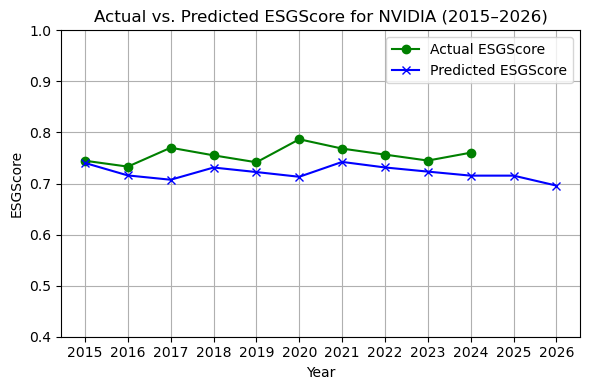

In [71]:
# Now re-train using all data for best future predictions
full_data = data_lagged.copy()  # full dataset from 2015–2024 after lagging and cleaning

# Define X and y for the entire time range
X_full = sm.add_constant(full_data[['ESGScore_lag1', 'ESGScore_lag2']])
y_full = full_data['ESGScore']

# Refit model on entire dataset
model_final = PanelOLS(y_full, X_full, entity_effects=True)
results_final = model_final.fit()
print("Refitted Model Summary on Full Data:")
print(results_final.summary)

def predict_future_esg_scores(model, data, start_year, end_year, company_isin):
    """
    Predict ESG scores iteratively for future years using the model.
    Assumes that data provided contains the last known lagged ESG scores
    and a Predicted_ESGScore column initialized from the latest known actual ESG score.
    """
    future_data = data.copy().reset_index()  # data should have columns: isin, year, ESGScore_lag1, ESGScore_lag2, Predicted_ESGScore
    
    predictions = []
    current_data = future_data.copy()

    for year in range(start_year, end_year + 1):
        # Set the year for prediction
        current_data['year'] = year

        # Account for initial case
        if year == start_year:
            current_data['ESGScore_lag1'] = current_data['ESGScore_lag1']
            current_data['ESGScore_lag2'] = current_data['ESGScore_lag2']
            
        # Proceed as 'normal', Use the last predicted ESG score as lag1, and shift lag1 to lag2
        else: 
            current_data['ESGScore_lag2'] = current_data['ESGScore_lag1']
            current_data['ESGScore_lag1'] = current_data['Predicted_ESGScore']

        # Set MultiIndex again
        current_data = current_data.set_index(['isin', 'year'])
        
        # Prepare X for prediction
        X_future = sm.add_constant(current_data[['ESGScore_lag1', 'ESGScore_lag2']])
        
        # Predict
        current_data['Predicted_ESGScore'] = model.predict(X_future)
        
        # Store the predictions of this iteration
        preds_for_year = current_data.reset_index()[['isin', 'year', 'ESGScore_lag1', 'ESGScore_lag2', 'Predicted_ESGScore']]
        predictions.append(preds_for_year)
        
        # Prepare for next iteration
        current_data = preds_for_year.copy()

    future_predictions = pd.concat(predictions, ignore_index=True)
    # Filter by the specific company if needed
    future_predictions_company = future_predictions[future_predictions['isin'] == company_isin]
    return future_predictions_company


# For forecasting 2025 and 2026, we need the latest known values from 2024.
# Extract the last known (2024) lag values and predicted values for each ISIN
# Since we now have a full model, let's assume actual ESG scores up to 2024.

latest_year_data = full_data.reset_index().groupby('isin').last()[['ESGScore_lag1','ESGScore_lag2']].copy()
# Initialize Predicted_ESGScore from the last known actual ESGScore_lag1 (i.e., treat the last known ESGScore as baseline)
# Since ESGScore_lag1 is the ESGScore from the previous year, we use it as the starting predicted score.
latest_year_data['Predicted_ESGScore'] = latest_year_data['ESGScore_lag1']
latest_year_data = latest_year_data.reset_index()

# Predict for 2025 and 2026
start_year = 2025
end_year = 2026
company_isin = 'US67066G1040'  # NVIDIA

future_predictions = predict_future_esg_scores(results_final, latest_year_data, start_year, end_year, company_isin)

print("Future ESG Score Predictions for NVIDIA (2025-2026):")
print(future_predictions)

# ------------------------------------------------
# Plot the Full Horizon (2015–2026) Including Future Predictions
# ------------------------------------------------
# Combine historical predictions (fitted values) with future predictions
full_results = full_data.copy()
full_results['Predicted_ESGScore'] = results_final.predict(sm.add_constant(full_results[['ESGScore_lag1','ESGScore_lag2']]))

# Append future predictions
# Future predictions don't have actual ESGScore, so we only have Predicted_ESGScore
future_predictions_for_plot = future_predictions.copy()
future_predictions_for_plot = future_predictions_for_plot.set_index(['isin', 'year'])

# Join back with full results (or just concatenate if needed)
# Since future years have no actual ESGScore, they won't appear in full_results. We'll just concat them.
future_predictions_for_plot['ESGScore'] = np.nan  # No actual for these future years
combined = pd.concat([full_results, future_predictions_for_plot[['ESGScore','Predicted_ESGScore']]])

company_data = combined.loc[company_isin].reset_index()
company_data['year'] = company_data['year'].astype(int)

x_values = company_data['year'].values
y_actual = company_data['ESGScore'].values
y_pred = company_data['Predicted_ESGScore'].values

plt.figure(figsize=(6, 4))
plt.plot(x_values, y_actual, marker='o', label='Actual ESGScore', color='green')
plt.plot(x_values, y_pred, marker='x', label='Predicted ESGScore', color='blue')

plt.title(f'Actual vs. Predicted ESGScore for NVIDIA (2015–2026)')
plt.xlabel('Year')
plt.ylabel('ESGScore')
plt.ylim(0.4, 1) 
plt.xticks(range(2015, 2027))  # Tick for each year
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('NVIDIA_prediction.png', dpi=500, bbox_inches='tight')
plt.show()


#### Checking autocorrelations to see if implementing a dynamic panel model makes sense/is worthwile

In [188]:
# Calculate autocorrelation for the ESGScore
for lag in range(1, 3):  # Check for lag-1 and lag-2
    correlation = data['ESGScore'].corr(data['ESGScore'].shift(lag))
    print(f"Autocorrelation with lag {lag}: {correlation:.4f}")

# Regress ESGScore on its lag to investigate autocorrelation
#X = sm.add_constant(data_clean['ESGScore_lag1'])  # Independent variable
#y = data_clean['ESGScore']  # Dependent variable

#model = sm.OLS(y, X).fit()
#print(model.summary())

Autocorrelation with lag 1: 0.8130
Autocorrelation with lag 2: 0.6463


#### Fixed Effects Model makes more sense but let's implement Random Effects model and perform the Hausman Test to investigate whether FE model is indeed better

In [147]:
from linearmodels.panel import RandomEffects
from scipy.stats import chi2

# Step 1: Fit the Random Effects Model
model_random = RandomEffects(y_train, X_train)
results_random = model_random.fit()

# Display Random Effects Model Summary
print("Random Effects Model Summary:")
print(results_random.summary)

# Step 2: Perform Hausman Test
# Extract the coefficients and variance-covariance matrix for both models
beta_fixed = results_fixed.params
beta_random = results_random.params
cov_fixed = results_fixed.cov
cov_random = results_random.cov

# Calculate the difference in coefficients and covariances
beta_diff = beta_fixed - beta_random
cov_diff = cov_fixed - cov_random

# Hausman Test Statistic
hausman_stat = beta_diff.T @ np.linalg.inv(cov_diff) @ beta_diff
p_value = chi2.sf(hausman_stat, len(beta_diff))

# Display Hausman Test Results
print("\nHausman Test Results:")
print(f"Statistic: {hausman_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpret Results
if p_value < 0.05:
    print("Reject Null Hypothesis: Use Fixed Effects Model")
else:
    print("Fail to Reject Null Hypothesis: Use Random Effects Model")

Random Effects Model Summary:
                        RandomEffects Estimation Summary                        
Dep. Variable:               ESGScore   R-squared:                        0.8832
Estimator:              RandomEffects   R-squared (Between):              0.9634
No. Observations:                2839   R-squared (Within):               0.3597
Date:                Mon, Dec 16 2024   R-squared (Overall):              0.8832
Time:                        19:45:52   Log-likelihood                    4007.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.073e+04
Entities:                         663   P-value                           0.0000
Avg Obs:                       4.2821   Distribution:                  F(2,2836)
Min Obs:                       0.0000                                           
Max Obs:                       6.0000   F-statistic (robust):          1.073e+0

# Note there are companies with only 1-2 observed years in the dataset, and there are also companies that only have data untill 2022 or 2023 or otherwise, there has not been done much investigation in this part of the dataset